<a href="https://colab.research.google.com/github/iamsauravsharma/insincere-question-classification/blob/bishal/dropout_and_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bishalgaire360","key":"69b39489849cd899eaa93339bad30cdb"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c quora-insincere-questions-classification
from zipfile import ZipFile
file_name="train.csv.zip"
#file_name="embeddings.zip"
with ZipFile(file_name,'r') as zip:
    zip.extractall()
    print('Done')
file_name="embeddings.zip"
with ZipFile(file_name,'r') as zip:
    zip.extractall()
    print('Done')
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
df=pd.read_csv('train.csv')
from tqdm import tqdm_notebook
import numpy as np
emb_file = "glove.840B.300d/glove.840B.300d.txt"
#emb_file ="GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin"
glove_dic = {}
for line in tqdm_notebook(open(emb_file)):
    temp = line.split(" ")
    glove_dic[temp[0]] = np.asarray(temp[1:],dtype='float32')

del df['qid']

 75% 41.0M/54.4M [00:00<00:00, 30.5MB/s]
100% 54.4M/54.4M [00:00<00:00, 65.8MB/s]
100% 5.94G/5.96G [00:38<00:00, 146MB/s]
100% 5.96G/5.96G [00:38<00:00, 167MB/s]
  0% 0.00/4.08M [00:00<?, ?B/s]
100% 4.08M/4.08M [00:00<00:00, 64.6MB/s]
 57% 9.00M/15.7M [00:00<00:00, 67.8MB/s]
100% 15.7M/15.7M [00:00<00:00, 76.7MB/s]
Done
Done


In [3]:
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x
df["question_text"] = df["question_text"].progress_apply(lambda x: clean_text(x))

100%|██████████| 1306122/1306122 [00:12<00:00, 106687.56it/s]


In [4]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab
sentences = df["question_text"].apply(lambda x: x.split()).values
vocab = build_vocab(sentences)

100%|██████████| 1306122/1306122 [00:04<00:00, 265633.46it/s]


In [5]:
n_words = len(vocab)+1
del vocab
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=0.1, random_state=42)


tokenizer = Tokenizer(num_words=n_words)
tokenizer.fit_on_texts(list(train.question_text))

q_train = tokenizer.texts_to_sequences(train.question_text)
q_val = tokenizer.texts_to_sequences(val.question_text)
#q_test = tokenizer.texts_to_sequences(df_test.question_text)

max_len = 65
q_train = pad_sequences(q_train,maxlen=max_len,padding='post')
q_val = pad_sequences(q_val,maxlen=max_len,padding='post')
#q_test = pad_sequences(q_test,maxlen=max_len)

y_train = train.target
y_val = val.target

del train,val
word_index = tokenizer.word_index
emb_size = glove_dic['.'].shape[0]
emb_matrix = np.zeros((n_words,emb_size))
for w,index in word_index.items():
    if index >= n_words:
        
        continue
    vec = glove_dic.get(w)
    if vec is not None:
        
        emb_matrix[index,:] = vec
        continue
    w = w.lower()
    vec = glove_dic.get(w)
    if vec is not None:
        
        emb_matrix[index,:] = vec
        continue
    w = w.upper()
    vec = glove_dic.get(w)
    if vec is not None:
        
        emb_matrix[index,:] = vec
        continue

    w = w.capitalize()
    vec = glove_dic.get(w)
    if vec is not None:
        
        emb_matrix[index,:] = vec
        continue
   


Using TensorFlow backend.


In [0]:
del glove_dic

In [0]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#find the best threshold
def optim_thres(y_val,y_pred):
    score = 0
    thresholds = np.arange(0.1,0.501,0.01)
    for thres in thresholds:
        thres = np.round(thres,2)
        temp_pred = (y_pred > thres).astype(int)
        temp_score = f1_score(y_val,temp_pred)
        print("Thres: {} --------- F1: {}".format(thres,temp_score))
        if temp_score > score:
            score = temp_score
            final_thres = thres
    return final_thres

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import gensim as gn
from tqdm import tqdm_notebook

from keras.layers import LSTM,Bidirectional,TimeDistributed, Embedding,Dense,Input,GlobalMaxPool1D,Flatten,Dropout
from keras.layers import CuDNNLSTM,CuDNNGRU
from keras.models import Sequential,Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam,Adamax
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        
    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import gensim as gn
from tqdm import tqdm_notebook

from keras.layers import LSTM,Bidirectional,TimeDistributed, Embedding,Dense,Input,GlobalMaxPool1D,Flatten,Dropout
from keras.layers import CuDNNLSTM,CuDNNGRU
from keras.models import Sequential,Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam,Adamax
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import LSTM,GRU,Bidirectional,TimeDistributed,Concatenate, Embedding,Dense,Input,GlobalMaxPool1D,Flatten,Dropout,Conv1D,Conv2D,MaxPooling1D,SpatialDropout1D,GlobalAveragePooling1D
from keras.layers import CuDNNLSTM,CuDNNGRU
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding,Flatten,Dense
from keras.optimizers import Adam,Adamax
from keras.engine.topology import Layer
from keras.layers.normalization import BatchNormalization


In [0]:
emb_size=300

In [0]:

inp = Input(shape=(max_len,))
x = Embedding(input_dim=n_words,output_dim=emb_size, weights=[emb_matrix])(inp)
#x = Embedding(input_dim=n_words,output_dim=embed_size, weights=[embedding_matrix])(inp)
x1 = Bidirectional(CuDNNLSTM(100,kernel_initializer='normal',kernel_regularizer=regularizers.l2(0.01), return_sequences=True))(x)
x2 = Bidirectional(CuDNNGRU(100,kernel_initializer='normal',kernel_regularizer=regularizers.l2(0.01), return_sequences=True))(x)
x1 = Conv1D(50,10,activation='relu')(x1)
x1 = GlobalMaxPool1D()(x)
x2 = Attention(step_dim=max_len)(x2)
conc = Concatenate()([x1, x2])
y = Dense(128,activation='elu')(conc)
y = Dense(64,activation='elu')(y)
y = Dropout(0.2)(y)
y = Dense(1, activation='sigmoid')(y)
model = Model(inputs=inp,output=y)
model.summary()

In [0]:
def getmodel(max_len,n_words,emb_size,emb_matrix,d):
    inp = Input(shape=(max_len,))
    x = Embedding(input_dim=n_words,output_dim=emb_size, weights=[emb_matrix])(inp)
    #x = Embedding(input_dim=n_words,output_dim=embed_size, weights=[embedding_matrix])(inp)
    x1 = Bidirectional(CuDNNLSTM(100,kernel_initializer='normal',kernel_regularizer=regularizers.l2(0.01), return_sequences=True))(x)
    x2 = Bidirectional(CuDNNGRU(100,kernel_initializer='normal',kernel_regularizer=regularizers.l2(0.01), return_sequences=True))(x)
    x1 = Conv1D(50,10,activation='relu')(x1)
    x1 = GlobalMaxPool1D()(x)
    x2 = Attention(step_dim=max_len)(x2)
    conc = Concatenate()([x1, x2])
    y = Dense(128,activation='elu')(conc)
    y = Dense(64,activation='elu')(y)
    y = Dropout(d)(y)
    y = Dense(1, activation='sigmoid')(y)
    model = Model(inputs=inp,output=y)
    return model

In [0]:
import matplotlib.pyplot as plt
dop=[0.1,0.2,0.3,0.4]

In [0]:
def opt(model): 
    print("---------------------------------------------------------------------------------------------------------------")
    model_name = 'lstm_glove_emb'
    checkpoint = ModelCheckpoint(filepath='./{}.hdf5'.format(model_name),
                             monitor='val_f1',mode='max',verbose=1,
                            save_best_only=True)

    adamax= Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.000)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1])
    history  = model.fit(q_train,y_train,batch_size=1500,epochs=7,validation_data=(q_val,y_val),verbose=1,callbacks=[checkpoint])
    return history
                         
    

In [0]:
def grapher(history):
    plt.plot(history.history['f1'])
    plt.plot(history.history['val_f1'])
    plt.title('Model accuracy')
    plt.ylabel('F1')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    return 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


---------------------------------------------------------------------------------------------------------------
Train on 1175509 samples, validate on 130613 samples
Epoch 1/7
1175509/1175509 [==============================] - 125s 106us/step - loss: 0.3103 - acc: 0.9508 - f1: 0.5114 - val_loss: 0.1077 - val_acc: 0.9575 - val_f1: 0.5819

Epoch 00001: val_f1 improved from -inf to 0.58189, saving model to ./lstm_glove_emb.hdf5
Epoch 2/7
1175509/1175509 [==============================] - 124s 105us/step - loss: 0.1037 - acc: 0.9588 - f1: 0.6284 - val_loss: 0.1049 - val_acc: 0.9588 - val_f1: 0.6277

Epoch 00002: val_f1 improved from 0.58189 to 0.62773, saving model to ./lstm_glove_emb.hdf5
Epoch 3/7
1175509/1175509 [==============================] - 124s 105us/step - loss: 0.0874 - acc: 0.9651 - f1: 0.6967 - val_loss: 0.1129 - val_acc: 0.9569 - val_f1: 0.5559

Epoch 00003: val_f1 did not improve from 0.62773
Epoch 4/7
1175509/1175509 [==============================] - 123s 105us/step - loss

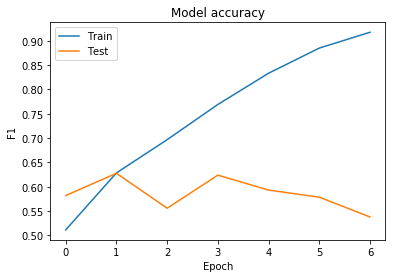

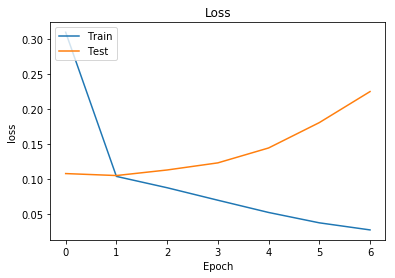

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


---------------------------------------------------------------------------------------------------------------
Train on 1175509 samples, validate on 130613 samples
Epoch 1/7
1175509/1175509 [==============================] - 125s 107us/step - loss: 0.3079 - acc: 0.9512 - f1: 0.5062 - val_loss: 0.1095 - val_acc: 0.9561 - val_f1: 0.5399

Epoch 00001: val_f1 improved from -inf to 0.53992, saving model to ./lstm_glove_emb.hdf5
Epoch 2/7
1175509/1175509 [==============================] - 123s 104us/step - loss: 0.1029 - acc: 0.9590 - f1: 0.6309 - val_loss: 0.1043 - val_acc: 0.9585 - val_f1: 0.6226

Epoch 00002: val_f1 improved from 0.53992 to 0.62258, saving model to ./lstm_glove_emb.hdf5
Epoch 3/7
1175509/1175509 [==============================] - 123s 104us/step - loss: 0.0875 - acc: 0.9650 - f1: 0.6955 - val_loss: 0.1096 - val_acc: 0.9562 - val_f1: 0.6470

Epoch 00003: val_f1 improved from 0.62258 to 0.64701, saving model to ./lstm_glove_emb.hdf5
Epoch 4/7
1175509/1175509 [=============

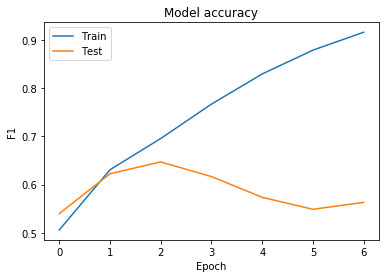

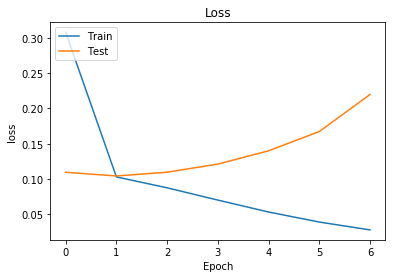

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


---------------------------------------------------------------------------------------------------------------
Train on 1175509 samples, validate on 130613 samples
Epoch 1/7
1175509/1175509 [==============================] - 126s 107us/step - loss: 0.3085 - acc: 0.9507 - f1: 0.5105 - val_loss: 0.1115 - val_acc: 0.9558 - val_f1: 0.5295

Epoch 00001: val_f1 improved from -inf to 0.52953, saving model to ./lstm_glove_emb.hdf5
Epoch 2/7
1175509/1175509 [==============================] - 123s 105us/step - loss: 0.1044 - acc: 0.9584 - f1: 0.6245 - val_loss: 0.1047 - val_acc: 0.9587 - val_f1: 0.6221

Epoch 00002: val_f1 improved from 0.52953 to 0.62214, saving model to ./lstm_glove_emb.hdf5
Epoch 3/7
1175509/1175509 [==============================] - 123s 105us/step - loss: 0.0892 - acc: 0.9645 - f1: 0.6908 - val_loss: 0.1101 - val_acc: 0.9556 - val_f1: 0.6395

Epoch 00003: val_f1 improved from 0.62214 to 0.63954, saving model to ./lstm_glove_emb.hdf5
Epoch 4/7
1175509/1175509 [=============

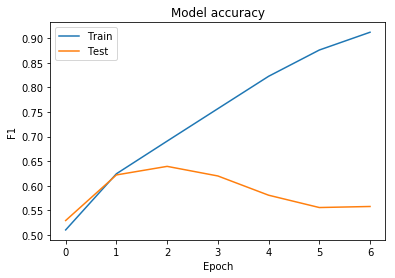

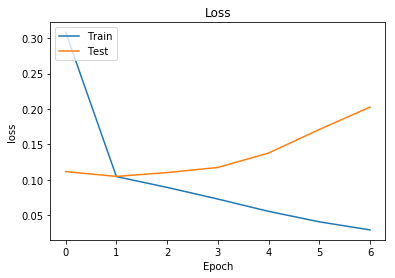

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


---------------------------------------------------------------------------------------------------------------
Train on 1175509 samples, validate on 130613 samples
Epoch 1/7
1175509/1175509 [==============================] - 126s 107us/step - loss: 0.3077 - acc: 0.9511 - f1: 0.5044 - val_loss: 0.1076 - val_acc: 0.9577 - val_f1: 0.5952

Epoch 00001: val_f1 improved from -inf to 0.59524, saving model to ./lstm_glove_emb.hdf5
Epoch 2/7
1175509/1175509 [==============================] - 123s 105us/step - loss: 0.1044 - acc: 0.9587 - f1: 0.6285 - val_loss: 0.1053 - val_acc: 0.9582 - val_f1: 0.5886

Epoch 00002: val_f1 did not improve from 0.59524
Epoch 3/7
1175509/1175509 [==============================] - 123s 104us/step - loss: 0.0891 - acc: 0.9646 - f1: 0.6921 - val_loss: 0.1080 - val_acc: 0.9583 - val_f1: 0.6158

Epoch 00003: val_f1 improved from 0.59524 to 0.61576, saving model to ./lstm_glove_emb.hdf5
Epoch 4/7
1175509/1175509 [==============================] - 123s 104us/step - loss

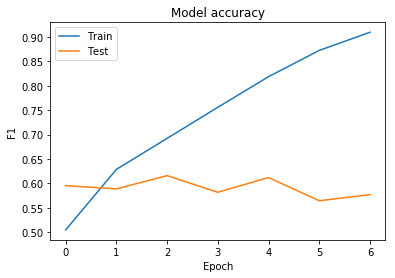

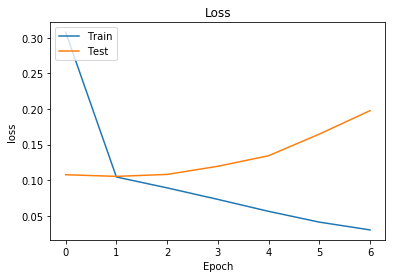

In [48]:
for i in range(0,len(dop)):
     model = getmodel(max_len=max_len,n_words=n_words,emb_size=emb_size,emb_matrix=emb_matrix,d=dop[i])
     his=opt(model)
     grapher(his)
     del model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


---------------------------------------------------------------------------------------------------------------
Train on 1175509 samples, validate on 130613 samples
Epoch 1/7
1175509/1175509 [==============================] - 128s 109us/step - loss: 0.3079 - acc: 0.9513 - f1: 0.5121 - val_loss: 0.1095 - val_acc: 0.9576 - val_f1: 0.6252

Epoch 00001: val_f1 improved from -inf to 0.62524, saving model to ./lstm_glove_emb.hdf5
Epoch 2/7
1175509/1175509 [==============================] - 124s 106us/step - loss: 0.1023 - acc: 0.9591 - f1: 0.6330 - val_loss: 0.1064 - val_acc: 0.9579 - val_f1: 0.6495

Epoch 00002: val_f1 improved from 0.62524 to 0.64952, saving model to ./lstm_glove_emb.hdf5
Epoch 3/7
1175509/1175509 [==============================] - 124s 105us/step - loss: 0.0868 - acc: 0.9651 - f1: 0.6995 - val_loss: 0.1077 - val_acc: 0.9580 - val_f1: 0.6126

Epoch 00003: val_f1 did not improve from 0.64952
Epoch 4/7
1175509/1175509 [==============================] - 124s 105us/step - loss

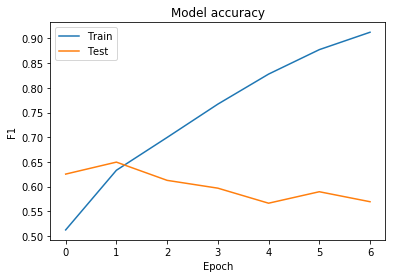

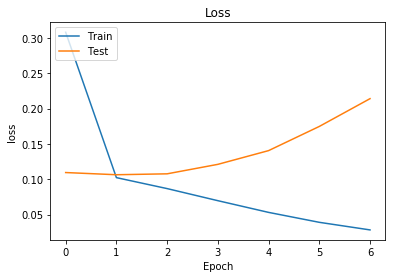

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


---------------------------------------------------------------------------------------------------------------
Train on 1175509 samples, validate on 130613 samples
Epoch 1/7
1175509/1175509 [==============================] - 128s 109us/step - loss: 0.3024 - acc: 0.9524 - f1: 0.5266 - val_loss: 0.1075 - val_acc: 0.9576 - val_f1: 0.5828

Epoch 00001: val_f1 improved from -inf to 0.58281, saving model to ./lstm_glove_emb.hdf5
Epoch 2/7
1175509/1175509 [==============================] - 124s 105us/step - loss: 0.1029 - acc: 0.9589 - f1: 0.6313 - val_loss: 0.1046 - val_acc: 0.9585 - val_f1: 0.6083

Epoch 00002: val_f1 improved from 0.58281 to 0.60825, saving model to ./lstm_glove_emb.hdf5
Epoch 3/7
1175509/1175509 [==============================] - 124s 105us/step - loss: 0.0869 - acc: 0.9650 - f1: 0.6974 - val_loss: 0.1074 - val_acc: 0.9579 - val_f1: 0.6001

Epoch 00003: val_f1 did not improve from 0.60825
Epoch 4/7
1175509/1175509 [==============================] - 123s 105us/step - loss

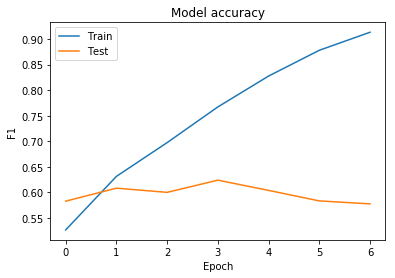

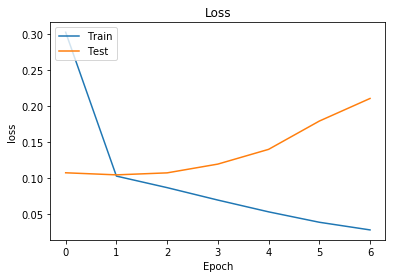

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


---------------------------------------------------------------------------------------------------------------
Train on 1175509 samples, validate on 130613 samples
Epoch 1/7
1175509/1175509 [==============================] - 129s 109us/step - loss: 0.3071 - acc: 0.9517 - f1: 0.5192 - val_loss: 0.1114 - val_acc: 0.9558 - val_f1: 0.6350

Epoch 00001: val_f1 improved from -inf to 0.63499, saving model to ./lstm_glove_emb.hdf5
Epoch 2/7
1175509/1175509 [==============================] - 124s 106us/step - loss: 0.1046 - acc: 0.9585 - f1: 0.6249 - val_loss: 0.1048 - val_acc: 0.9583 - val_f1: 0.5982

Epoch 00002: val_f1 did not improve from 0.63499
Epoch 3/7
1175509/1175509 [==============================] - 124s 106us/step - loss: 0.0896 - acc: 0.9643 - f1: 0.6894 - val_loss: 0.1073 - val_acc: 0.9583 - val_f1: 0.6357

Epoch 00003: val_f1 improved from 0.63499 to 0.63571, saving model to ./lstm_glove_emb.hdf5
Epoch 4/7
1175509/1175509 [==============================] - 124s 106us/step - loss

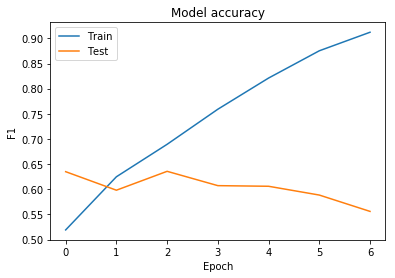

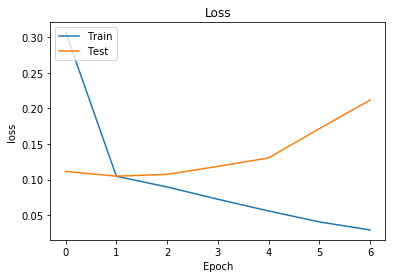

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


---------------------------------------------------------------------------------------------------------------
Train on 1175509 samples, validate on 130613 samples
Epoch 1/7
1175509/1175509 [==============================] - 129s 110us/step - loss: 0.3053 - acc: 0.9516 - f1: 0.5152 - val_loss: 0.1166 - val_acc: 0.9547 - val_f1: 0.6429

Epoch 00001: val_f1 improved from -inf to 0.64293, saving model to ./lstm_glove_emb.hdf5
Epoch 2/7
1175509/1175509 [==============================] - 124s 106us/step - loss: 0.1048 - acc: 0.9584 - f1: 0.6235 - val_loss: 0.1061 - val_acc: 0.9580 - val_f1: 0.5856

Epoch 00002: val_f1 did not improve from 0.64293
Epoch 3/7
1175509/1175509 [==============================] - 124s 106us/step - loss: 0.0898 - acc: 0.9642 - f1: 0.6886 - val_loss: 0.1077 - val_acc: 0.9573 - val_f1: 0.6452

Epoch 00003: val_f1 improved from 0.64293 to 0.64517, saving model to ./lstm_glove_emb.hdf5
Epoch 4/7
1175509/1175509 [==============================] - 124s 106us/step - loss

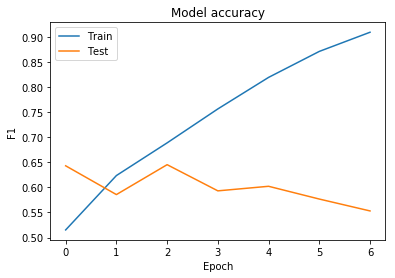

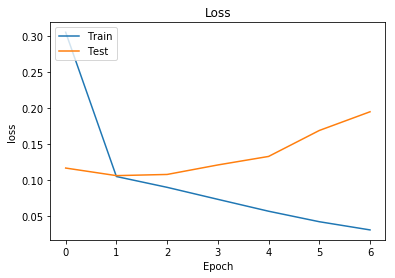

In [51]:
#admax optimizer
for i in range(0,len(dop)):
     model = getmodel(max_len=max_len,n_words=n_words,emb_size=emb_size,emb_matrix=emb_matrix,d=dop[i])
     his=opt(model)
     grapher(his)
     del model

In [0]:
 model = getmodel(max_len=max_len,n_words=n_words,emb_size=emb_size,emb_matrix=emb_matrix,d=dop[i])
    
                        
    #del model
                        
    